<a href="https://colab.research.google.com/github/Raiyan-DEA/Dataframe_content/blob/main/2_Model_Evaluation_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# STEP 1: Install and Import Required Libraries
!pip install -q imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [4]:
# STEP 2: Load Dataset (Telco Churn)
# url = "https://raw.githubusercontent.com/blastchar/telco-churn/master/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(r'C:\Users\georg\OneDrive\Desktop\DEA\Python for Analytics\Machine Learning\WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.dropna(inplace=True)


In [5]:
# STEP 3: Encode Target Column
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])

In [6]:
print(df['Churn'])

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int32


In [7]:
# STEP 4: Convert Non-Numeric Columns
cat_cols = df.select_dtypes(include='object').columns.drop('customerID')
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


In [8]:
# STEP 5: Train/Test Split
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)



In [9]:
# STEP 6: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# STEP 7: Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)


In [11]:
# STEP 8: Evaluate Model (Before Balancing)
print("Before Handling Imbalance")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Before Handling Imbalance
[[1612  185]
 [ 348  321]]
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1797
           1       0.63      0.48      0.55       669

    accuracy                           0.78      2466
   macro avg       0.73      0.69      0.70      2466
weighted avg       0.77      0.78      0.77      2466



Before SMOTE (Imbalanced)

True Negatives (TN): 1612 (non-churn predicted correctly)

False Positives (FP): 185 (non-churn predicted as churn)

False Negatives (FN): 348 (missed churners)

True Positives (TP): 321 (churn predicted correctly)

In [12]:
# STEP 9: Handle Imbalanced Classes with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

model_smote = LogisticRegression(max_iter=1000)
model_smote.fit(X_res, y_res)
y_pred_smote = model_smote.predict(X_test_scaled)

In [13]:
# STEP 10: Evaluate Model (After SMOTE)
print("After Handling Imbalance (SMOTE)")
print(confusion_matrix(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))



After Handling Imbalance (SMOTE)
[[1550  247]
 [ 308  361]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1797
           1       0.59      0.54      0.57       669

    accuracy                           0.77      2466
   macro avg       0.71      0.70      0.71      2466
weighted avg       0.77      0.77      0.77      2466



After SMOTE (Balanced)

Slight drop in TN (1550 vs. 1612)

More churners correctly identified: 361 vs. 321

Fewer missed churners (FN): 308 vs. 348

In [ ]:
# Classification Report Comparison
# Metric	      Class	    Before	After	Interpretation
# Precision	     1 (churn)	0.63	0.59	Slight drop — more false positives after balancing
# Recall	     1 (churn)	0.48	0.54	Improved — fewer missed churners, key for churn!
# F1-score	     1 (churn)	0.55	0.57	Small gain — better overall churn class performance
# Accuracy       Overall	0.78	0.77	Slight dip — expected when trying to fix imbalance
# Macro Avg F1	 All	    0.70	0.71	Improved — better balance between churn and non-churn

In [ ]:
# Interpretation

# What Improved
# Recall for churners (class 1) increased from 48% → 54%, meaning the model is now catching more actual churners.

# F1-score for churners also increased slightly (55% → 57%).

# What Slightly Declined
# Precision for churners dropped (63% → 59%) → you're now predicting "churn" more often, 
# but with slightly more false positives.

# Overall accuracy dropped a little (78% → 77%) — but this is expected when focusing more on minority class performance.

# Business Takeaway
# Before balancing, the model was biased toward predicting non-churners, missing over half of actual churners.

# After SMOTE, the model became better at catching churners, 
# which is crucial in churn analysis, even at the cost of some false alarms.

# In practice, missing a churner is more costly than a false positive, so this trade-off is likely worth it.

# # Recommendation
# Use the SMOTE-balanced model if your goal is to retain customers 
# — better recall means you’ll catch more likely churners and can act on them.

# Consider threshold tuning (e.g., predict_proba with a custom threshold) or cost-sensitive learning 
# to optimize for churn recall further.

# # Plot an ROC or Precision-Recall curve to visualize this trade-off more clearly.

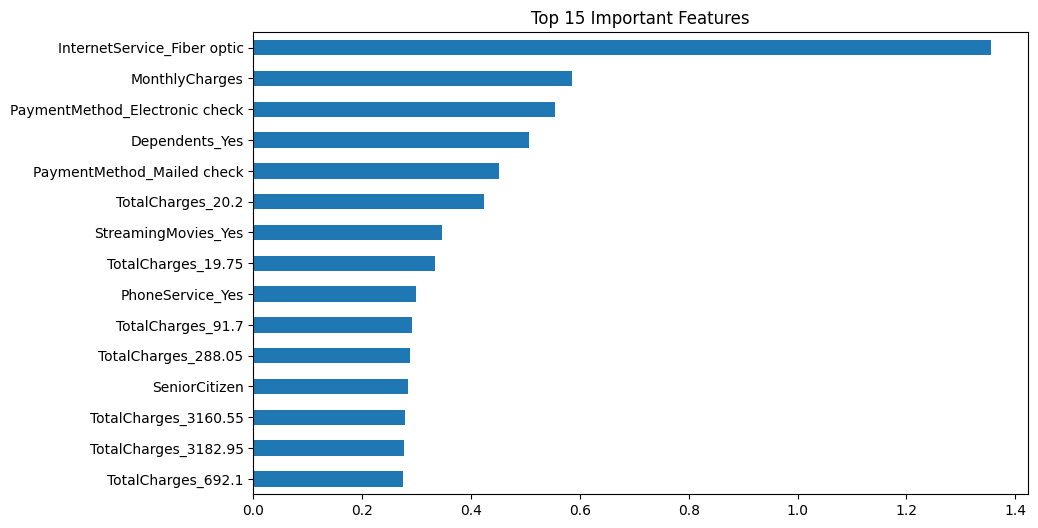

In [15]:
# STEP 11: Feature Importance
importance = pd.Series(model_smote.coef_[0], index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importance.head(15).plot(kind='barh')
plt.title("Top 15 Important Features")
plt.gca().invert_yaxis()
plt.savefig('top_15_important_features.png')
plt.show()